<a href="https://colab.research.google.com/github/326eunjin/ai-team_project/blob/main/6_2_4_37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
import scipy as sp
from tensorflow import keras
from tensorflow.keras.models import clone_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical,plot_model
import plotly.graph_objects as go

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Preprocess the data
#y_train y_test 원래의 클래스의 레이블 정보 보존을 위해 따로 저장
y_train_origin = y_train
y_test_origin = y_test
x_train = x_train.astype('float32') / 255.0 #정규화
y_train = to_categorical(y_train) #one-hot encoding
x_test = x_test.astype('float32') / 255.0 #정규화
y_test = to_categorical(y_test) #one-hot encoding 

In [3]:
# #original model Test Accuracy:  0.7023000121116638
# model = tf.keras.models.Sequential([
#     Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(64, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])
#layer 0.7267000079154968 0.7376999855041504

model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(512, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# #channel Test Accuracy:  0.7063999772071838
# model = tf.keras.models.Sequential([
#     Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(256, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])
# #dense 늘리기 Test Accuracy:  0.7124000191688538
# model = tf.keras.models.Sequential([
#     Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(256, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(10, activation='softmax')
# ])

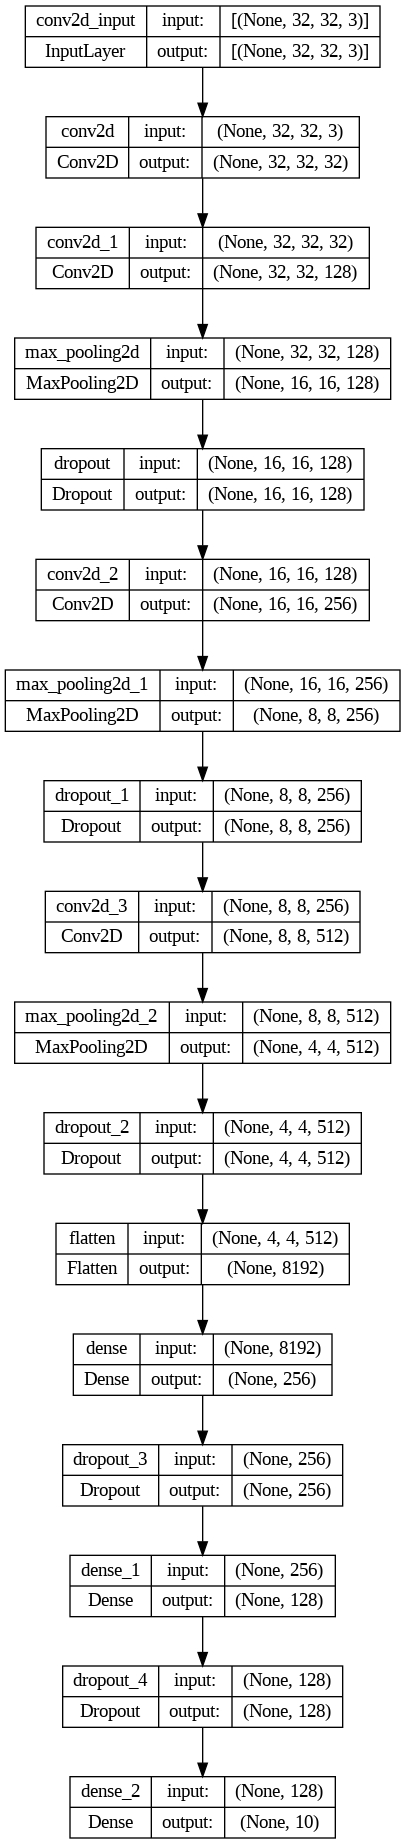

In [4]:
# model 시각화
plot_model(model, show_shapes=True)

In [5]:
def get_kmeans_loss():
  features = model.predict(x_train)
  # Apply K-means clustering for manifold space learning and design loss function
  kmeans = KMeans(n_clusters=10, random_state=0)
  kmeans.fit(features)
  kmeans_labels = kmeans.labels_

  # Calculate centroids manually
  centroids = []
  for i in range(kmeans.n_clusters):
      cluster_points = features[kmeans_labels == i]
      centroid = np.mean(cluster_points, axis=0)
      centroids.append(centroid)
  kmeans_loss = [0 for _ in range(10)]
  for i in range(len(y_train)):
    min = float('INF')
    for j in range(10):
      tmp = np.linalg.norm(y_train[i] - centroids[j], 2)
      min = tmp if min > tmp else min
    kmeans_loss[np.argmax(y_train[i])] += min
  return kmeans_loss

In [6]:
tf.config.run_functions_eagerly(True)

#kmeans_loss = tf.constant(kmeans_loss)
#Vol.1 Euclidean distance 지금 1등
def my_loss1(label, predict):
  np_label = np.array(label)
  loss_table = [kmeans_loss[np.argmax(np_label[i])] for i in range(len(np_label))]
  #for i in range(len(label)):
  #  tmp += kmeans_loss[np.argmax(np_label[i])]
  #loss = tf.norm(label-predict,2)*tmp
  loss = tf.norm(label-predict,2) * loss_table
  return loss


#Vol.2 Cosine similarity 나가리
def my_loss2(label, predict):
  cosine_similarity = tf.tensordot(label, tf.transpose(predict),axes=1)/(tf.norm(label,2)*tf.norm(predict,2))
  loss = 1 - cosine_similarity
  return loss * 100

#Vol.3 Manhattan distance
# Test Accuracy:  0.4722000062465668 그닥 좋지 않음 ㅠ_ㅠ
def my_loss3(label, predict):
  loss = tf.norm(label - predict,1)
  return loss




In [7]:
batch_size=64
model.compile(optimizer='adam',
              loss=my_loss1,
              metrics=['accuracy'])

In [8]:
log_dir = './logs/tensorflow'
tensorboard_cb=keras.callbacks.TensorBoard(log_dir)

In [ ]:
for _ in range(5):
  print(f"{_} times:")
  kmeans_loss = get_kmeans_loss()
  model.fit(x_train, y_train, batch_size=batch_size, epochs=10, callbacks=[tensorboard_cb])
  
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest Accuracy: ',test_acc)
print('Test Loss: ',test_loss)

0 times:


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1563/1563 [==============================] - 25s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/10
782/782 [==============================] - 60s 76ms/step - loss: 4969.8940 - accuracy: 0.7531
Epoch 2/10
782/782 [==============================] - 59s 76ms/step - loss: 4891.8936 - accuracy: 0.7597
Epoch 3/10
607/782 [======================>.......] - ETA: 13s - loss: 4847.4272 - accuracy: 0.7643

In [10]:
# Apply PCA for dimensionality reduction of intermediate features
pca = PCA(n_components=3)

In [11]:
# ## Visualization of intermediate model 1 evaluation

# # Apply PCA for dimensionality reduction of intermediate features 1
# intermediate_model1 = Sequential(model.layers[:-2])
# intermediate_features1 = intermediate_model1.predict(x_test)
# reduced_intermediate_features1 = pca.fit_transform(intermediate_features1)

# # Create a trace for the scatter plot
# scatter_trace = go.Scatter3d(
#     x=reduced_intermediate_features1[:, 0],
#     y=reduced_intermediate_features1[:, 1],
#     z=reduced_intermediate_features1[:, 2],
#     mode='markers',
#     marker=dict(
#         color=y_test_origin.flatten()*10,
#         colorscale='Viridis',
#         size=3,
#         opacity=0.8
#     )
# )

# # Create the layout
# layout = go.Layout(
#     scene=dict(
#         xaxis=dict(title='Dimension 1'),
#         yaxis=dict(title='Dimension 2'),
#         zaxis=dict(title='Dimension 3')
#     ),
#     title='Visualization of intermediate model evaluation'
# )

# # Create the figure
# fig = go.Figure(data=[scatter_trace], layout=layout)

# # Resize the figure
# fig.update_layout(width=800, height=800)

# # Show the figure
# fig.show()


In [12]:
## Visualization of intermediate model evaluation

# Apply PCA for dimensionality reduction of intermediate features
intermediate_model = Sequential(model.layers[:-1])
intermediate_features = intermediate_model.predict(x_test)
reduced_intermediate_features = pca.fit_transform(intermediate_features)

# Create a trace for the scatter plot
scatter_trace = go.Scatter3d(
    x=reduced_intermediate_features[:, 0],
    y=reduced_intermediate_features[:, 1],
    z=reduced_intermediate_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten()*10,
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    title='Visualization of intermediate model evaluation'
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Resize the figure
fig.update_layout(width=800, height=800)

# Show the figure
fig.show()


313/313 [==============================] - 3s 9ms/step


In [13]:
## Visualization of model evaluation

# Apply PCA for dimensionality reduction of test features
test_features = model.predict(x_test)
reduced_test_features = pca.fit_transform(test_features)

# Create a trace for the scatter plot
scatter_trace = go.Scatter3d(
    x=reduced_test_features[:, 0],
    y=reduced_test_features[:, 1],
    z=reduced_test_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten()*10,
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    title='Visualization of model evaluation'
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Resize the figure
fig.update_layout(width=800, height=800)

# Show the figure
fig.show()


  6/313 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



313/313 [==============================] - 3s 10ms/step


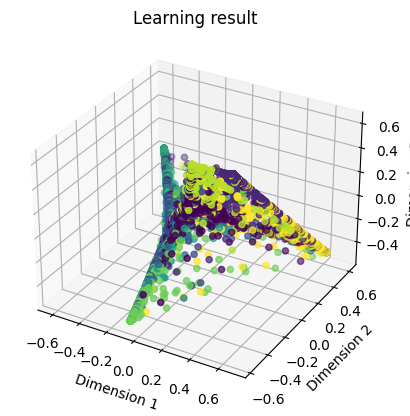

In [14]:
# Visualize 3D surface with K-means labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_test_features[:, 0], reduced_test_features[:, 1], reduced_test_features[:, 2], c=y_test_origin, cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title('Learning result')
plt.show()

In [15]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[4].output, model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       36992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                             

In [16]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 10)

In [18]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 32 x 32
        features (array) -- features of the image, shape (1, 8, 8, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (32/8, 32/8, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (32,32))
 
    # visualize the results
    print(f'softmax output: {results}')
    category = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    print(f"prediction: {category[tf.argmax(results[0])]}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()
  
  show_cam(x_train,)

IndentationError: ignored